# Final Anomaly Detection 

### Original Data and Other Necessary Data Pieces

Here are all the libraries and modules we will need.

In [1]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
import regex as re
from tqdm import tqdm
import scipy

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tqdm.keras import TqdmCallback

We set seeds to ensure reproducibility.

In [2]:
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
os.chdir(r'C:\Users\corri\OneDrive\Documents\GitHub\Advanced-Cyber-Analytics-for-Attack-Detection\Anomaly Detection')

Here we import the original data - these are the data summaries.

In [4]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)
    
    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The list of known red team users, which is assumed to be comprehensive, is required later on for analysis of techniques. We'll also obtain a list of non red-team users and a sample of them to employ when testing the algorithms.

In [5]:
rt_usernames = list(pd.read_csv('../Data/AuthUserNames.txt', header=None)[0])
non_rt_users = [un for un in authentication_data['UserName'].unique() if un not in rt_usernames]
non_rt_sample = random.sample(non_rt_users,200)

For data creation later we require a list of authentication types - this can be created here.

In [6]:
a_t = list(authentication_data['Authent Type'].unique())
AT_dict = { i : a_t[i] for i in range(0, len(a_t) ) }

Finally, we require a list of the seperation points in our data frame. Each day can be seperated out by indexing and we find the indices here.

In [7]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

### Data Creation for Anomaly Detction

#### Main Data Creation Functions

This first function is used to split a data frame into equal chunks. Since we need to split each day into 8/24 hours we use this function to split into equal time periods - this may not be perfectly representitive of the actual hour split but should be a good estimate since we don't have the original time stamps.

In [8]:
def split_dataframe(df,n):
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [9]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

#### Authentication Type Data

This function creates the authentication type data frames . It takes as input a username and a split by number (8/24) and returns a data frame of the user's authentiation events split by type over 90 days, split by 8/24 hours.

In [10]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

#### Various Count Data

This function creates a data frame of other features. It includes counts from various possible features that we could've chosen.

In [11]:
def feature_generation(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

#### Adjacency Data

In [12]:
try:
    print('Reading Data.')
    data_frame_list_uase = pickle.load(open('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Data Frame List UASE.p','rb'))
    index_sparse = pickle.load(open('Index UASE.p','rb'))
    columns_sparse = pickle.load(open('Columns UASE.p','rb'))
    
except:
    clear_output()
    print('Creating Data Frames.')
    data_frame_list_uase = []

    start_time = datetime.datetime.now()

    for i in tqdm(range(len(auth_start_days)-1)):

        data_frame_ind = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))

        chunk = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
        data_un ={}
        for user in authentication_data['UserName'].unique():
            dstdevice_data = chunk[chunk['UserName'] == user].groupby('DstDevice').size()
            data_un[user] = data_frame_ind.index.to_series().map(dstdevice_data.to_dict())

        data_frame_ind = pd.DataFrame(data=data_un,index = list(authentication_data['DstDevice'].unique()))
        data_frame_ind = data_frame_ind.notnull().astype('int')
        data_frame_ind = data_frame_ind.fillna(0)
        A = np.array(data_frame_ind)
        sA = sparse.csr_matrix(A)
        data_frame_list_uase.append(sA)    

    index_sparse = data_frame_ind.index
    columns_sparse = data_frame_ind.columns
    pickle.dump(data_frame_list_uase, open('Data Frame List UASE.p', 'wb'))
    pickle.dump(index_sparse, open('Index UASE.p', 'wb'))
    pickle.dump(columns_sparse, open('Columns UASE.p', 'wb'))
    print(datetime.datetime.now()-start_time)

Reading Data.


#### Supervised Data

We turn our anomaly detection exercise into a supervised problem here.

In [13]:
def feature_generation_supervised(user,n,anom):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
            
            hour = j
            data = chunks[j]
            
            if 57 <= i+1 <= 82 and anom==True:
                anombool = 1
            else:
                anombool = 0

            authents = len(data[data['UserName'] == user])
            failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
            srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
            dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
            uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
            feat_dict[i*n + j] = [user,srcunique,dstunique,authents,failures,anombool]
            #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['UserName','SrcUnique','DstUnique','Authentications','Failures','Anomaly'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

### Anomaly Detection

#### Isolation Forest and Local Outlier Factor Detection

In [14]:
def scaled_iso_lof(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # isolation forest predictions
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    
    # local outlier factor predictions
    lof = LocalOutlierFactor(n_neighbors=2)
    lof_predictions = lof.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_if = auth_types_pca.loc[if_predictions == -1]
        a_lof = auth_types_pca.loc[lof_predictions == -1]
        
        anomalies = auth_types_pca.loc[list(set(a_lof.index) & set(a_if.index))]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of combined anomalies found: {}. \n Number of LOF anomalies found: {}. \n Number of IF anomalies found: {}.'.format(len(anomalies), len(a_lof), len(a_if))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_if = data.loc[if_predictions == -1]
        a_lof = data.loc[lof_predictions == -1]
        
        anomalies = data.loc[list(set(a_lof.index) & set(a_if.index))]
    
    return anomalies

In [15]:
# rt_if_lof_anomalies = []

# for un in rt_usernames:
#     data = auth_type_un_df(un,14)

In [16]:
#data = auth_type_un_df(rt_usernames[0],14)
#scaled_iso_lof(data,plot=False,c='auto')

#### Auto Encoder AD

The first function allows us to work back from the anomalies produced by the auto-encoder to obtain the original anomalies.

In [17]:
def ae_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    
    return data

Here we define our best auto encoder anomaly detection function from the 6 we built - built from https://csce.ucmss.com/cr/books/2019/LFS/CSREA2019/ICA2282.pdf

In [30]:
def ae_anomaly_finder(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the data frame of features
    df = feature_generation(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [26]:
try:
    print('Reading Data.')
    anomalies_ae_5 = pickle.load(open('Anomalies AE VL.p','rb'))
    val_loss_5 = pickle.load(open('Validation Loss VL.p','rb'))
    anomaly_bool_5 = []
    anomalies_ae_5 = anomalies_ae_5.drop_duplicates()
    
    for un in rt_usernames:
        try:
            anomaly_bool_5.append((len(anomalies_ae_5[anomalies_ae_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_5 = []
    anomaly_bool_5 = []
    val_loss_5 = []

    s_time = datetime.datetime.now()

    for i in range(len(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder(rt_usernames[i],24)
        if b == 1:
            frames_5.append(f)
            anomaly_bool_5.append((len(f),rt_usernames[i]))
            val_loss_5.append((val,rt_usernames[i]))
        else:
            anomaly_bool_5.append((0,rt_usernames[i]))
            val_loss_5.append((val,rt_usernames[i]))
            pass
    anomalies_ae_5 = pd.concat(frames_5)
    
    pickle.dump(anomalies_ae_5, open('Anomalies AE VL.p','wb'))
    pickle.dump(val_loss_5, open('Validation Loss VL.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

Data available.


This analyses the results from the auto-encoder.

In [27]:
def simple_ae_eval(anomaly_bools,anomalies,val_losses,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    final_losses = []
    for i in range(len(val_losses)):
        final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

    plt.figure()
    sns.boxplot(data = final_losses)
    plt.show()
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

88 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User409683, User133028, User089536, User859748, User630088, User457932, User758916, User829941, User900703, User497510, User222822
14.75% of the red team data was identified as anomalous.


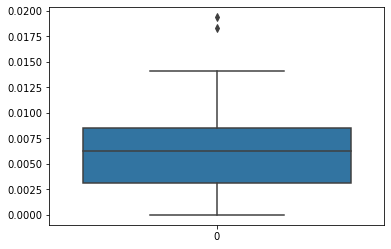

Authent Type
Batch                    189
CachedInteractive         77
InteractiveLogon         588
NetworkLogon            7995
RemoteInteractive        212
ScreensaverDismissed     200
ScreensaverInvoked       204
Service                  463
TGS                     8540
TGT                     2548
WorkstationLock          581
WorkstationUnlock        797
dtype: int64


In [28]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,rt_usernames,'red team')

In [31]:
try:
    print('Reading Data.')
    non_rt_sample = random.sample(non_rt_users,bound)
    anomalies_ae_n_5 = pickle.load(open('Non RT Anomalies.p','rb'))
    val_loss_n_5 = pickle.load(open('Non RT VL.p','rb'))
    anomaly_bool_N_5 = []
    anomalies_ae_n_5 = anomalies_ae_n_5.drop_duplicates()

    for un in non_rt_sample:
        try:
            anomaly_bool_N_5.append((len(anomalies_ae_n_5[anomalies_ae_n_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_N_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_n_5 = []
    anomaly_bool_N_5 = []
    val_loss_n_5 = []
    bound = 400

    s_time = datetime.datetime.now()

    for i,un in enumerate(non_rt_sample):
        f,b,val = ae_anomaly_finder(un,24)
        if b == 1:
            frames_n_5.append(f)
            anomaly_bool_N_5.append((len(f),un))
            val_loss_n_5.append((val,un))
        else:
            anomaly_bool_N_5.append((0,un))
            val_loss_n_5.append((val,un))
            pass
    anomalies_ae_n_5 = pd.concat(frames_n_5)
    pickle.dump(anomalies_ae_n_5,open('Non RT Anomalies.p','wb'))
    pickle.dump(val_loss_n_5,open('Non RT VL.p','wb'))
    pickle.dump(non_rt_sample,open('Random Sample of Non Red Team Usernames.p','wb'))
    e_time = datetime.datetime.now()
    print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
No anomalies found.
1:51:21.363239


336 of the normal usernames were identified to have anomalies out of 400 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User558903, User439048, Comp623389$, User939034, User565970, User262941, User703488, User159815, User845839, Comp014951$, User896647, Comp499682$, Comp775436$, User125119, User602494, User901705, User799647, User894599, Comp216772$, User936556, User882175, User946590, User428181, User799659, User486339, Comp317443$, Comp261013$, User573468, User387455, User764890, Comp008365$, Comp629361$, User674811, User467601, User616026, Comp398685$, User325958, User670114, Comp628167$, Comp393779$, User546230, User501826, Comp416325$, User854203, User101046, User338382, Comp989146$, Comp380170$, Comp027416$, User276491, Comp758007$, Comp216216$, Comp492299$, User496596, User443647, Comp760116$, Comp277773$, User362650, User860058, Comp887177$, Comp497770$, User6

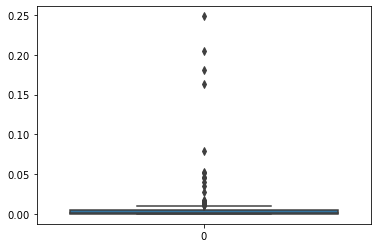

Authent Type
CachedInteractive          96
InteractiveLogon          729
NetworkLogon            14012
RemoteInteractive         142
ScreensaverDismissed      478
ScreensaverInvoked        467
Service                    21
TGS                     23357
TGT                      6150
WorkstationLock          1208
WorkstationUnlock        1559
dtype: int64


In [32]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### Poisson AD

Here we run a Poisson anomaly detection algorithm.

Based on a gamma prior for a poisson distribution, we can estimate $ \lambda $ by $ \frac{(\sum{x_{i}} + \alpha)}{(n + \beta)}$. This is because under a $\Gamma(\alpha,\beta)$ prior for $\lambda$ we have that the posterior is $$ \pi(\lambda|x) \propto \lambda^{\sum{x_{i}}+\alpha-1} e^{-(n+\beta)\lambda}$$

This allows us to find anomalies based on the output of our poisson model.

In [33]:
def poiss_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    
    return data

Here we define the Poisson anomaly detection model. We define the model with both the possibility to combine and not combine here.

In [34]:
def poiss_ae_detection(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in tqdm(enumerate(usernames)):

        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for col in pois_df.columns:
            dt = pois_df.iloc[:57*n][col]
            bayes_mean.append((alpha+sum(dt))/(beta+len(dt)))
            bayes_var.append((alpha+sum(dt))/(beta+len(dt))**2)

        probabilities = stats.poisson.pmf(pois_df.iloc[57*n:82*n],bayes_mean)
        
        if comb == True:
            for i in range(len(probabilities)):

                prob = probabilities[i]

                f_probs.append(stats.combine_pvalues(prob))
            for i in range(len(f_probs)):

                pv = f_probs[i][1]

                if pv <= 0.05:
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
        elif comb == False:
            for i in range(len(probabilities)):
                
                prob = probabilities[i]
                
                if any(prob <= 0.05):
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
    events = pd.concat(events_frames)
    return events

Here we define our analysis for the poisson anomaly detection model.

In [35]:
def simple_poiss_eval(anomaly_bools,anomalies,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

This block of code runs and analyses the models predictions on the red team data when combining results using Fisher's method.

In [36]:
s_time = datetime.datetime.now()
poisson_anoms = poiss_ae_detection(list(set(rt_usernames)),24,True)

poisson_anoms = poisson_anoms.drop_duplicates()
poiss_anom_bool = []

for un in rt_usernames:
    if un in list(poisson_anoms['UserName']):
        poiss_anom_bool.append((1,un))
    else:
        poiss_anom_bool.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool,poisson_anoms,list(set(rt_usernames)),'red team')



0it [00:00, ?it/s]C:\Users\corri\anaconda3\lib\site-packages\scipy\stats\stats.py:7661: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


1it [00:04,  4.76s/it]

2it [00:08,  4.44s/it]

3it [00:13,  4.28s/it]

4it [00:17,  4.39s/it]

5it [00:21,  4.37s/it]

6it [00:26,  4.31s/it]

7it [00:31,  4.50s/it]

8it [00:36,  4.67s/it]

9it [00:40,  4.52s/it]

10it [00:45,  4.62s/it]

11it [00:49,  4.66s/it]

12it [00:54,  4.77s/it]

13it [00:59,  4.58s/it]

14it [01:03,  4.50s/it]

15it [01:07,  4.44s/it]

16it [01:12,  4.42s/it]

17it [01:16,  4.54s/it]

18it [01:21,  4.49s/it]

19it [01:26,  4.60s/it]

20it [01:31,  4.72s/it]

21it [01:35,  4.54s/it]

22it [01:39,  4.46s/it]

23it [01:44,  4.57s/it]

24it [01:49,  4.72s/it]

25it [01:53,  4.56s/it]

26it [01:58,  4.60s/it]

27it [02:02,  4.52s/it]

28it [02:07,  4.66s/it]

29it [02:12,  4.67s/it]

30it [02:16,  4.69s/it]

31it [02:21,  4.57s/it]

32it [02:25,  4.52s/it]

33it [02:30,  4.48s/it]


0:07:13.824025
90 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User133028, User702833, User859748, User457932, User829941, User405399, User900703, User497510, User222822
14.71% of the red team data was identified as anomalous.
Authent Type
Batch                    199
CachedInteractive        101
InteractiveLogon         647
NetworkLogon            8717
RemoteInteractive        232
ScreensaverDismissed     199
ScreensaverInvoked       196
Service                  453
TGS                     7817
TGT                     2416
WorkstationLock          538
WorkstationUnlock        815
dtype: int64


This block of code runs and analyses the poisson model on the red team data when not combining.

In [38]:
s_time = datetime.datetime.now()
poisson_anoms_nc = poiss_ae_detection(rt_usernames,24,False)

poisson_anoms_nc = poisson_anoms_nc.drop_duplicates()
poiss_anom_bool_nc = []

for un in rt_usernames:
    if un in list(poisson_anoms_nc['UserName']):
        poiss_anom_bool_nc.append((1,un))
    else:
        poiss_anom_bool_nc.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_nc,poisson_anoms_nc,rt_usernames,'red team')



0it [00:00, ?it/s]

1it [00:04,  4.81s/it]

2it [00:09,  4.77s/it]

3it [00:14,  4.83s/it]

4it [00:19,  5.01s/it]

5it [00:23,  4.71s/it]

6it [00:28,  4.77s/it]

7it [00:33,  4.80s/it]

8it [00:37,  4.59s/it]

9it [00:42,  4.65s/it]

10it [00:47,  4.68s/it]

11it [00:51,  4.52s/it]

12it [00:56,  4.72s/it]

13it [01:00,  4.54s/it]

14it [01:05,  4.63s/it]

15it [01:10,  4.68s/it]

16it [01:14,  4.50s/it]

17it [01:19,  4.57s/it]

18it [01:24,  4.67s/it]

19it [01:29,  4.90s/it]

20it [01:33,  4.68s/it]

21it [01:38,  4.72s/it]

22it [01:43,  4.74s/it]

23it [01:48,  4.76s/it]

24it [01:52,  4.77s/it]

25it [01:57,  4.75s/it]

26it [02:02,  4.75s/it]

27it [02:07,  4.92s/it]

28it [02:12,  4.87s/it]

29it [02:16,  4.62s/it]

30it [02:21,  4.66s/it]

31it [02:25,  4.69s/it]

32it [02:30,  4.70s/it]

33it [02:35,  4.71s/it]

34it [02:40,  4.88s/it]

35it [02:45,  4.84s/it]

36it [02:50,  4.81s/it]

37it [02:54,  4.77s/it]

38it [02:59,  4.78s/it]

39it [03:04,  4.77s/it]

40it [03:09,

0:07:47.529822
98 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
16.96% of the red team data was identified as anomalous.
Authent Type
Batch                     200
CachedInteractive         133
InteractiveLogon          733
NetworkLogon            10545
RemoteInteractive         264
ScreensaverDismissed      210
ScreensaverInvoked        207
Service                   454
TGS                      9000
TGT                      2560
WorkstationLock           569
WorkstationUnlock         873
dtype: int64


This block of code runs and analyses the poisson model for the non red team username sample when not combining.

In [39]:
s_time = datetime.datetime.now()

poisson_anoms_n = poiss_ae_detection(non_rt_sample,24,False)

poisson_anoms_n = poisson_anoms_n.drop_duplicates()
poiss_anom_bool_n = []

for un in non_rt_sample:
    if un in list(poisson_anoms_n['UserName']):
        poiss_anom_bool_n.append((1,un))
    else:  
        poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_n,poisson_anoms_n,non_rt_sample,'norma

SyntaxError: EOL while scanning string literal (<ipython-input-39-09c9ffaaad9a>, line 15)

#### Inhomogenous Poisson AD

Here we define our 'inhomohenous' poisson model. For each day we calculate an independent poisson $ \lambda $.

In [ ]:
def inhom_poiss_ae_detection_2(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in enumerate(usernames):
        
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(un_ct+1,len(usernames),100*((un_ct+1)/len(usernames))))
        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for i in range(n):
            bayes_mean_hr = []
            bayes_var_hr = []
            for col in pois_df.columns:
                dt = list(pd.concat([pois_df.iloc[:57*n],pois_df.iloc[83*n:]])[col])
                dt_hspl = dt[i::n]
                bayes_mean_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl)))
                bayes_var_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl))**2)

            bayes_mean.append(bayes_mean_hr)
            bayes_var.append(bayes_var_hr)
        
        find_prob = []
        for i in range(n):
            find_prob.append(pd.DataFrame(stats.poisson.pmf(pd.concat([pois_df.iloc[:57*n], pois_df.iloc[83*n:]]).iloc[i::n],bayes_mean[i])).min())
                
        probabilities = []
        
        for i in range(n):

            probabilities.append(stats.poisson.pmf(pois_df.iloc[57*n:82*n].iloc[i::n],bayes_mean[i]))

        for i in range(n):

            probs = probabilities[i]

            for j in range(len(probs)):

                hr_prob = probs[j]
                
                thresh = find_prob[i]
                
                if [item1 for item1,item2 in zip(hr_prob,thresh) if item1 <= item2] != []:

                    events_frames.append(poiss_orig_finder(un,n,57*n+j*n+i))

    events = pd.concat(events_frames)
    
    return events

Here we run our inhomogenous poisson model on the red team data.

In [ ]:
s_time = datetime.datetime.now()
poisson_anoms_inhom = inhom_poiss_ae_detection_2(rt_usernames,24,False)

poisson_anoms_inhom = poisson_anoms_inhom.drop_duplicates()
poiss_anom_bool_inhom = []

for un in rt_usernames:
    if un in list(poisson_anoms_inhom['UserName']):
        poiss_anom_bool_inhom.append((1,un))
    else:
        poiss_anom_bool_inhom.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_inhom,poisson_anoms_inhom,rt_usernames,'red team')

Here we run our inhomogenous model on the non-red team data.

In [ ]:
s_time = datetime.datetime.now()

inhom_poisson_anoms_n = inhom_poiss_ae_detection_2(non_rt_sample,24,False)

inhom_poisson_anoms_n = inhom_poisson_anoms_n.drop_duplicates()
inhom_poiss_anom_bool_n = []

for un in non_rt_sample:
    if un in list(inhom_poisson_anoms_n['UserName']):
        inhom_poiss_anom_bool_n.append((1,un))
    else:
        inhom_poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(inhom_poiss_anom_bool_n,inhom_poisson_anoms_n,non_rt_sample,'normal')

#### Supervised Neural Network AD

Here we create our data for our supervised neural network data and turn the task of unsupervised anomaly detection into supervised anomaly detection.

In [ ]:
username_sample = list(pd.Series(rt_usernames).unique()) + non_rt_sample
data = []
for user in tqdm(username_sample):
    if user in rt_usernames:
        anom = 1
    else:
        anom = 0
    df = feature_generation_supervised(user,24,anom)
    data.append(df)
nn_data = pd.concat(data)
nn_data.to_csv('nn_supervised data.gz', compression='gzip')
X_train, X_test, y_train, y_test = train_test_split(nn_data[['UserName','SrcUnique','DstUnique','Authentications','Failures']], nn_data['Anomaly'], test_size=0.1, random_state=42)
X_train_un_list = list(X_train['UserName'])
X_test_un_list = list(X_test['UserName'])
X_train = X_train.drop('UserName',axis=1)
X_test = X_test.drop('UserName',axis=1)

In [ ]:
def nn_anomaly_finder(x_train,x_test,y_train,y_test,train_user,test_user,n,BATCH_SIZE=256, EPOCHS=1000):
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train)
    x_train = pipeline.transform(x_train)
    x_test = pipeline.transform(x_test)
    
    # define neural network parameters
    input_dim = x_train.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the nn
    neural_network =Sequential([

        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])

    # compile the autoencoder
    neural_network.compile(optimizer="adam", 
                        loss='binary_crossentropy',
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = neural_network.fit(
        x_train, y_train,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = neural_network.predict(x_test)
    Y_pred = x_test_pred.argmax(axis=1)
    test_loss, test_acc = neural_network.evaluate(X_test, y_test)
    print(test_acc)
    
    anomalies = x_test[np.where(x_test_pred == 1)]
    #anomaly_idx = anomalies[0]
    
    #frame = []
    #for i in range(len(anomaly_idx)):
    #    user = test_user[anomaly_idx[i]]
    #    anomaly = nn_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
    #    if len(anomaly) == 0:
    #        pass
    #    else:
    #        frame.append(anomaly)
    #    
    #if len(frame) != 0:
    #    anomaly_df = pd.concat(frame)
    #    return anomaly_df,1,history.history["val_loss"]
    #else:
    #    print('No anomalies found.')
    #    return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]
    return Y_pred

In [ ]:
Y_pred = nn_anomaly_finder(X_train,X_test,y_train,y_test,X_train_un_list,X_test_un_list,24,BATCH_SIZE=256, EPOCHS=1000)
pd.DataFrame(Y_pred).groupby(0).size()

#### ASE AD

Here we implement the ASE function based on - https://arxiv.org/pdf/2008.10055.pdf, https://jscholarship.library.jhu.edu/bitstream/handle/1774.2/37075/SUSSMAN-DISSERTATION-2014.pdf

In [ ]:
def ASE_anom_finder(window_length):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    for t in tqdm(range(len(data_frame_list_uase)-1)):
        u1, s1, v1 = scipy.sparse.linalg.svds(data_frame_list_uase[t],k=7)
        u2, s2, v2 = scipy.sparse.linalg.svds(data_frame_list_uase[t+1],k=7)
        Y1 = pd.DataFrame((v1.transpose()*np.abs(s1)**0.5).transpose(),columns=(list(set(columns_sparse))))
        Y2 = pd.DataFrame((v2.transpose()*np.abs(s2)**0.5).transpose(),columns=(list(set(columns_sparse))))

        nrm = scipy.linalg.norm(Y2-Y1,ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        for v in list(columns_sparse):
            nrm = scipy.linalg.norm(Y2[v]-Y1[v],ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t >= window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.std([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)

    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][2] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][2] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][0] for k in range(len(vertex_range_tracker))])
        anomalies = [j+window_length for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

In [ ]:
vertex_norm_tracker_7, graph_norm_tracker_7, graph_mam_tracker_7, graph_range_tracker_7, vertex_mam_tracker_7, vertex_range_tracker_7, day_anomalies_7 = ASE_anom_finder(7)
vertex_norm_tracker_14, graph_norm_tracker_14, graph_mam_tracker_14, graph_range_tracker_14, vertex_mam_tracker_14, vertex_range_tracker_14, day_anomalies_14 = ASE_anom_finder(14)
vertex_norm_tracker_3, graph_norm_tracker_3, graph_mam_tracker_3, graph_range_tracker_3, vertex_mam_tracker_3, vertex_range_tracker_3, day_anomalies_3 = ASE_anom_finder(3)
vertex_norm_tracker_2, graph_norm_tracker_2, graph_mam_tracker_2, graph_range_tracker_2, vertex_mam_tracker_2, vertex_range_tracker_2, day_anomalies_2 = ASE_anom_finder(2)
vertex_norm_tracker_5, graph_norm_tracker_5, graph_mam_tracker_5, graph_range_tracker_5, vertex_mam_tracker_5, vertex_range_tracker_5, day_anomalies_5 = ASE_anom_finder(5)

We also produce plots of the data here.

In [ ]:
def plot_creation(window_length,vertex_mam_tracker,vertex_range_tracker,vertex_norm_tracker,u):
    
    plt.figure(figsize = (16,8))  
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),[vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),np.array([vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][0] for k in range(len(vertex_range_tracker))]),'--')
    plt.plot([vertex_norm_tracker[k][u] for k in range(len(vertex_norm_tracker))],'r.')
    plt.xlabel('Day')
    plt.ylabel('$||{X_{i}^{(t+1)}-X_{i}^{(t)}}||$')
    plt.title('Window Length: {}'.format(window_length))
    plt.show()
    
    return

The below code finds a red team user and plots it.

In [ ]:
rt_user_idx = []
for i,un in enumerate(columns_sparse):
    b = un in list(rt_usernames)
    if b == True:
        rt_user_idx.append(i)

plot_creation(14,vertex_mam_tracker_14,vertex_range_tracker_14,vertex_norm_tracker_14,idx[0])
plot_creation(7,vertex_mam_tracker_7,vertex_range_tracker_7,vertex_norm_tracker_7,idx[0])
plot_creation(5,vertex_mam_tracker_5,vertex_range_tracker_5,vertex_norm_tracker_5,idx[0])
plot_creation(3,vertex_mam_tracker_3,vertex_range_tracker_3,vertex_norm_tracker_3,idx[0])
plot_creation(2,vertex_mam_tracker_2,vertex_range_tracker_2,vertex_norm_tracker_2,idx[0])

### Combining Anomaly Detection Techniques

### Final Anomaly Dataset